# K-NN On Amazon Fine Food Reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


### Objective
* To classify the positive and negative reviews.

###  How to classify?
* By applying vectorization techniques such as BOW, TF-IDF , Avg W2V and TF-IDF weighted W2V.
* Applying K-nn on above vectors. 
* Column used to check the Acuracy will be Score.
  - Positive review (rating 4-5)
  - Negative review (rating 1-2)

## Loading Data

In [1]:
%matplotlib inline
import warnings as wr
wr.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

con = sqlite3.connect('database.sqlite') #building connnection with database
review_data = pd.read_sql_query('''select * from Reviews where Score != 3''',con)#importing data from database

#function to replace rating with 1(+ve) or 0(-ve)
def Replace_rate(x):
    if x < 3:
        return 0
    else:
        return 1

OldScore = review_data['Score']
NewScore = OldScore.map(Replace_rate)
review_data['Score'] = NewScore
print('Review data is loaded with {0} rows and {1} columns'.format(review_data.shape[0],review_data.shape[1]))
review_data.head()



Review data is loaded with 525814 rows and 10 columns


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Data Preprocessing

### Removing duplicate data

In [2]:
#Checking for duplicate data 
duplicate_data = pd.read_sql_query('''select UserId, ProductId, ProfileName, Time, Score, Text, count(*) as count from Reviews where 
Score != 3 group by UserId having count(*) > 1 ''',con)

duplicate_data.shape

(75346, 7)

In [3]:
#removing duplicate data
print('Data before de-duplication had {} rows and {} columns'.format(review_data.shape[0],review_data.shape[1]))
review_data = review_data.sort_values('ProductId',axis = 0, ascending=True, inplace=False, kind='quicksort', na_position='last')

review_data = review_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print('Data after de-duplication had {} rows and {} columns'.format(review_data.shape[0],review_data.shape[1]))

Data before de-duplication had 525814 rows and 10 columns
Data after de-duplication had 364173 rows and 10 columns


In [4]:
# Helpfulness denominator should be always greater than numerator
review_data = review_data[review_data.HelpfulnessNumerator <= review_data.HelpfulnessDenominator]
review_data.shape

(364171, 10)

### Cleaning the data
* Removing html tags
* Removing stopwords
* Converting words to lower case
* Removing alphanumeric value 
* Lemmitizing the data

In [5]:
import re
import os
import nltk
import string
from tqdm import tqdm
from nltk.corpus import stopwords 

sno = nltk.stem.SnowballStemmer('english')#initialise stemmer
stop = set(stopwords.words('english'))

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


if not os.path.isfile('final.sqlite'):
    final_string = []
    for i, sent in enumerate(tqdm(review_data['Text'].values)):
        filtered_sentence=[]
        sent = cleanhtml(sent)
        for w in sent.split():
            for cleanwords in cleanpunc(w).split():
                #we are spliting the data two time because after first splitting there may be a possibility that we can get a word
                # 'abc.def' which after the second split will become two words 'abc' 'def'
                if((cleanwords.isalpha()) and (len(cleanwords)>2)): # there is no adjective with length 2
                    if(cleanwords.lower() not in stop):
                        s=(sno.stem(cleanwords.lower())).encode('utf8')
                        filtered_sentence.append(s)
        str1 = b" ".join(filtered_sentence)
        final_string.append(str1)
        

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [04:53<00:00, 1240.10it/s]


In [6]:
#storing the data in a database(.sqlite file)
review_data['CleanedText'] = final_string
review_data['CleanedText']=review_data['CleanedText'].str.decode("utf-8")
conn = sqlite3.connect('final.sqlite')
c = conn.cursor()
conn.text_factory = str
review_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
conn.close()

In [7]:
#importing preprocessed data into a new dataframe
conn = sqlite3.connect('final.sqlite')
preprocessed_data = pd.read_sql_query('''select * from Reviews limit 20000''',conn)
print(preprocessed_data.shape)
preprocessed_data.head()

(20000, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [8]:
#https://www.programiz.com/python-programming/datetime/strftime
#converting given time with format %m/%d/%Y, %H:%M:%S
from datetime import datetime

timestamp = preprocessed_data['Time']
time_data=[]
for i in timestamp:
    date_time = datetime.fromtimestamp(i)
    d = date_time.strftime("%m/%d/%Y, %H:%M:%S")
    time_data.append(d)

preprocessed_data['Time'] = time_data

#sorting values according to time for the time base splitting
processed_data = preprocessed_data.sort_values('Time',axis=0).reset_index(drop=True)
processed_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,516061,557949,B0000DJDL4,A1Y20KNCR0SZA1,"Dessartfamily ""grandmasoven""",8,9,1,"01/01/2004, 05:30:00",The best Kringles ever,Others try to make kringles but there is only ...,other tri make kringl one bakeri make real dan...
1,446972,483251,B0005ZX38Q,A3F7DP6OW7X6CE,"Cathy Razim ""RazCat""",3,4,1,"01/01/2006, 05:30:00",Totally Yum!,I'm a college student and I found this product...,colleg student found product campus store firs...
2,420655,454893,B00032EGHI,A1XBSM55RTS2IT,"Celine Johnson ""C. Johnson""",8,8,1,"01/01/2006, 05:30:00",Vanilla Coke is On Hiatus,I just read a press release from Coca-Cola tha...,read press releas vanilla coke put hiatus best...
3,309826,335493,B0002HVDNY,A3FVAWZNKW9GX,"A.Trendl HungarianBookstore.com ""What should ...",1,2,1,"01/01/2006, 05:30:00",Slowly Smoked Pork is Delicious,I buy Karaj Hungarian Pork Loin regularly at o...,buy karaj hungarian pork loin regular local hu...
4,77542,84346,B0000DGF5S,AQDTYG93O2WYO,Paul L. Bardzik,15,16,0,"01/01/2006, 05:30:00",Broken pot,"Not sure if the plant is going to survive, The...",sure plant go surviv pot broken open box yet s...


## Applying Brute Force K-NN

### Splitting Data Based on Time

In [10]:
#splitting the data into train and test set
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split

X = processed_data['CleanedText']
Y = processed_data['Score']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)

### Function for Finding Optimal K

In [13]:
# this function is defined to reduce the coding effort to find k value for each vectorization technique
def optimal_k_val(x,y,alg = 'brute'):
    
    # creating odd list of K for KNN
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))
    
    # empty list that will hold cv scores
    cv_scores = []
    
    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k,algorithm = alg)
        scores = cross_val_score(knn, x, y, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())
    
    # changing to misclassification error
    MSE = [1 - i for i in cv_scores]
    
    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)
    
    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)
    
    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()
    return optimal_k

## Bag Of Words

In [14]:
#vectorizing train data for BOW
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
x_train_bow = count_vect.fit_transform(x_train)
x_test_bow = count_vect.transform(x_test)
print(x_train_bow.shape)
print(x_test_bow.shape)

(13400, 16447)
(6600, 16447)



The optimal number of neighbors is 7.


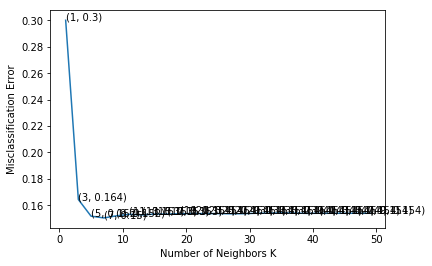

In [15]:
#getting optimal_k 
optimal_k=optimal_k_val(x=x_train_bow,y=y_train)

### Brute Force

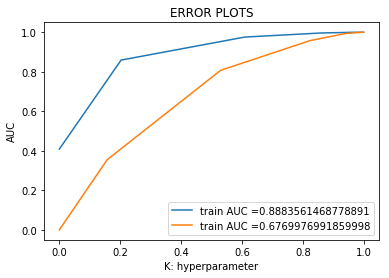

In [16]:
from sklearn.metrics import roc_curve, auc

neigh = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'brute')
neigh.fit(x_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(x_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix on Train Data

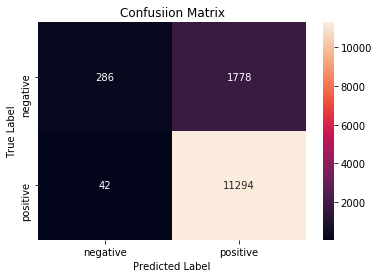

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.87      0.14      0.24      2064
          1       0.86      1.00      0.93     11336

avg / total       0.87      0.86      0.82     13400



In [18]:
# predict the response
y_pred_bow = neigh.predict(x_train_bow)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')

print(classification_report(y_train ,y_pred_bow))

### Confusion MAtrix on Test  Data

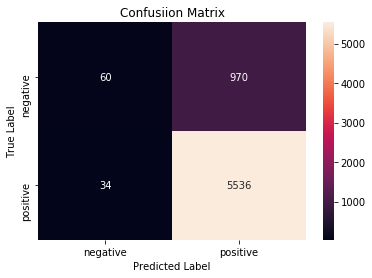

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.64      0.06      0.11      1030
          1       0.85      0.99      0.92      5570

avg / total       0.82      0.85      0.79      6600



In [19]:
# predict the response
y_pred_bow = neigh.predict(x_test_bow)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')

print(classification_report(y_test ,y_pred_bow))

### Kd_tree


The optimal number of neighbors is 9.


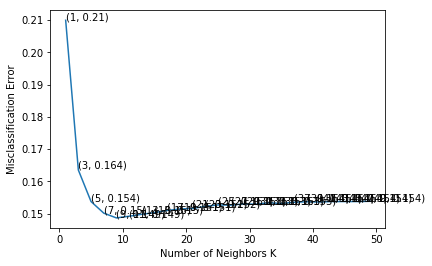

In [21]:
# using less features
import warnings as wr
wr.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

count_vect = CountVectorizer(min_df = 10,max_features = 500)
x_train_bow = count_vect.fit_transform(x_train)
x_test_bow = count_vect.transform(x_test)

x_train_bow = x_train_bow.todense()
x_test_bow = x_test_bow.todense()
scale= StandardScaler()
x_train_bow_stand = scale.fit_transform(x_train_bow)
x_test_bow_stand = scale.transform(x_test_bow)

#finding best hyperparameter 
optimal_k = optimal_k_val(x=x_train_bow_stand,y=y_train,alg = 'kd_tree')


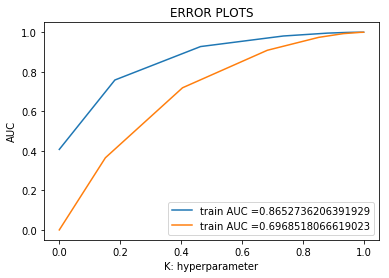

In [22]:
# instantiate learning model k = optimal_k
neigh = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'kd_tree')
neigh.fit(x_train_bow_stand, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(x_train_bow_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test_bow_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix for Train data

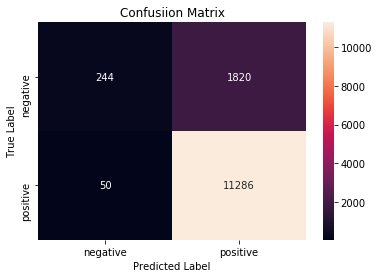

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.83      0.12      0.21      2064
          1       0.86      1.00      0.92     11336

avg / total       0.86      0.86      0.81     13400



In [23]:
# predict the response
y_pred_bow = neigh.predict(x_train_bow_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_train ,y_pred_bow))

### Confusion Matrix on Test Data

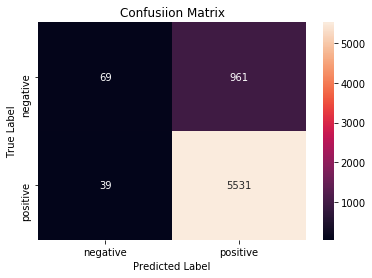

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.64      0.07      0.12      1030
          1       0.85      0.99      0.92      5570

avg / total       0.82      0.85      0.79      6600



In [24]:
# predict the response
y_pred_bow = neigh.predict(x_test_bow_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_test ,y_pred_bow))

## TF-IDF

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
x_train_tfidf = tf_idf_vect.fit_transform(x_train)
x_test_tfidf = tf_idf_vect.transform(x_test)
print(x_train_tfidf.shape)
print(x_test_tfidf.shape)

(13400, 7792)
(6600, 7792)



The optimal number of neighbors is 11.


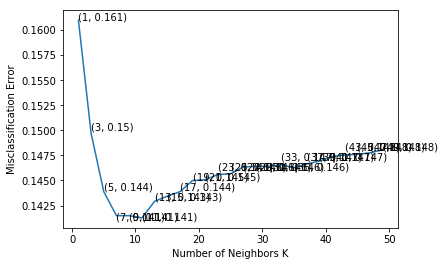

In [26]:
#getting optimal_k value
optimal_k = optimal_k_val(x=x_train_tfidf,y=y_train)

### Brute 

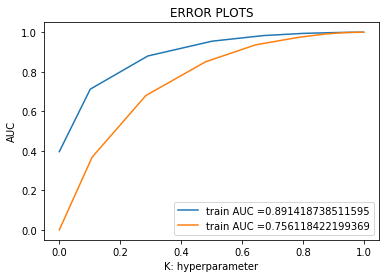

In [27]:
from sklearn.metrics import roc_curve, auc

neigh = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'brute')
neigh.fit(x_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(x_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


### Confusion Matrix on Train Data

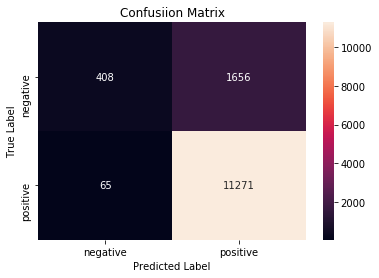

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.86      0.20      0.32      2064
          1       0.87      0.99      0.93     11336

avg / total       0.87      0.87      0.84     13400



In [29]:
# predict the response
y_pred_tfidf = neigh.predict(x_train_tfidf)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_tfidf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_train ,y_pred_tfidf))

### Confusion Matrix on Test Data

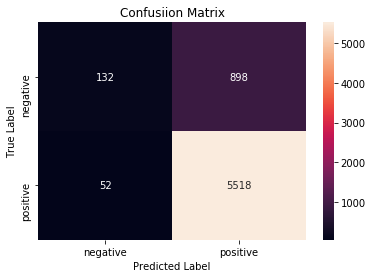

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.72      0.13      0.22      1030
          1       0.86      0.99      0.92      5570

avg / total       0.84      0.86      0.81      6600



In [30]:
# predict the response
y_pred_tfidf = neigh.predict(x_test_tfidf)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_tfidf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_test ,y_pred_tfidf))

### Kd_tree


The optimal number of neighbors is 15.


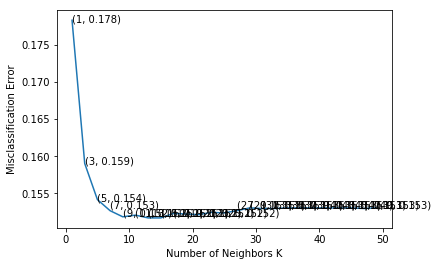

In [31]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features = 500)
x_train_tfidf = tf_idf_vect.fit_transform(x_train)
x_test_tfidf = tf_idf_vect.transform(x_test)

x_train_tfidf = x_train_tfidf.todense()
x_test_tfidf = x_test_tfidf.todense()

x_train_tfidf_stand = scale.fit_transform(x_train_tfidf)
x_test_tfidf_stand = scale.transform(x_test_tfidf)

optimal_k = optimal_k_val(x=x_train_tfidf_stand,y=y_train,alg = 'kd_tree')

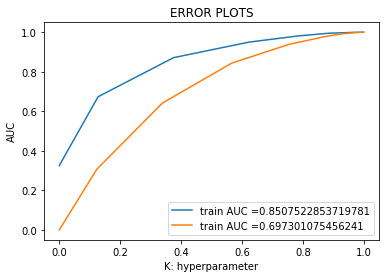

In [32]:
from sklearn.metrics import roc_curve, auc

neigh = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'kd_tree')
neigh.fit(x_train_tfidf_stand, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(x_train_tfidf_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test_tfidf_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


### Confusion Matrix on Train Data

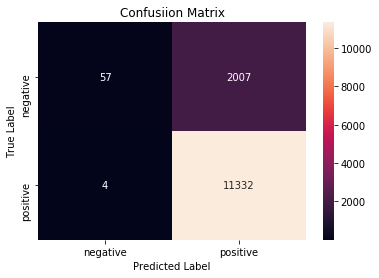

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.93      0.03      0.05      2064
          1       0.85      1.00      0.92     11336

avg / total       0.86      0.85      0.79     13400



In [33]:
# predict the response
y_pred_tfidf = neigh.predict(x_train_tfidf_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_tfidf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_train ,y_pred_tfidf))

### Confusion Matrix on Test Data

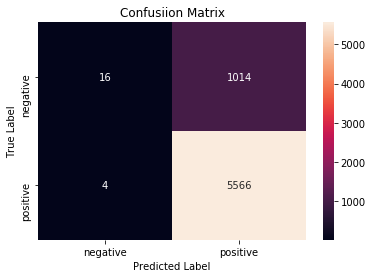

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.80      0.02      0.03      1030
          1       0.85      1.00      0.92      5570

avg / total       0.84      0.85      0.78      6600



In [34]:
# predict the response
y_pred_tfidf = neigh.predict(x_test_tfidf_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_tfidf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_test ,y_pred_tfidf))

## Avg W2V

### Creating W2V for train data

In [42]:
#function for creating avg word2vector
from gensim.models import Word2Vec

list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

x_train_avgw2v = np.array(sent_vectors)

### Using Train Model to vectorize Test data

In [44]:
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

x_test_avgw2v = np.array(sent_vectors)

(13400, 50)
(6600, 50)

The optimal number of neighbors is 15.


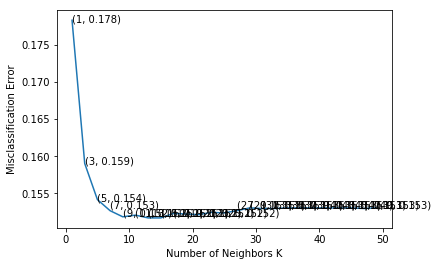

In [46]:
x_train_avgw2v_stand = scale.fit_transform(x_train_avgw2v)
x_test_avgw2v_stand = scale.transform(x_test_avgw2v)
print(x_train_avgw2v_stand.shape)
print(x_test_avgw2v_stand.shape)

#getting optimal_k value
optimal_k = optimal_k_val(x=x_train_tfidf_stand,y=y_train)

### Brute

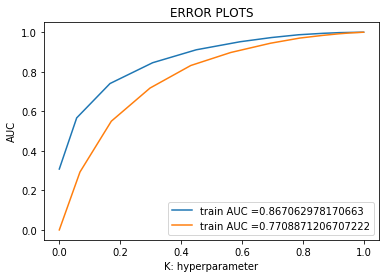

In [47]:
from sklearn.metrics import roc_curve, auc

neigh = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'brute')
neigh.fit(x_train_avgw2v_stand, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(x_train_avgw2v_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test_avgw2v_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix for Train data

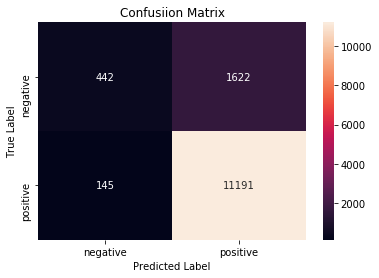

In [49]:
# predict the response
y_pred_avgw2v = neigh.predict(x_train_avgw2v_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train,y_pred_avgw2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Confusion Matrix for Test data

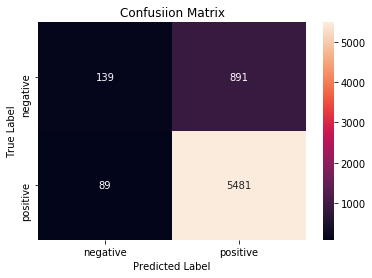

In [50]:
# predict the response
y_pred_avgw2v = neigh.predict(x_test_avgw2v_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred_avgw2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Kd_tree


The optimal number of neighbors is 15.


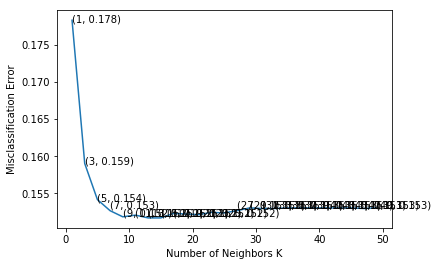

In [51]:
#getting optimal_k value
optimal_k = optimal_k_val(x=x_train_tfidf_stand,y=y_train,alg = 'kd_tree')

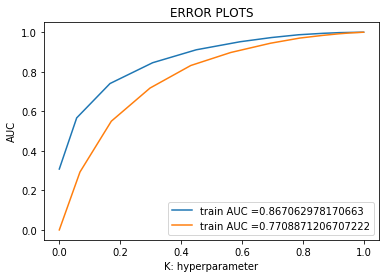

In [52]:
from sklearn.metrics import roc_curve, auc

neigh = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'kd_tree')
neigh.fit(x_train_avgw2v_stand, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(x_train_avgw2v_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test_avgw2v_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix for train data

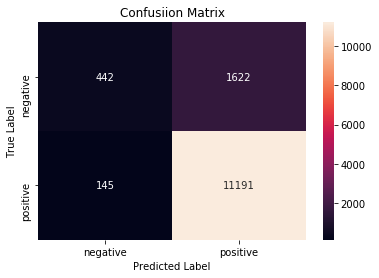

In [53]:
# predict the response
y_pred_avgw2v = neigh.predict(x_train_avgw2v_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train,y_pred_avgw2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Confusion Matrix for test data

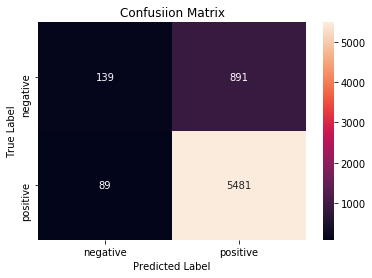

In [54]:
# predict the response
y_pred_avgw2v = neigh.predict(x_test_avgw2v_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred_avgw2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## TF-IDF Weighted W2V

### Creating a tf-idf weighted w2v for train data

In [61]:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
def weighted_word_vector(model,x):
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    list_of_sentance=[]
    for sentance in x:
        list_of_sentance.append(sentance.split())
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in list_of_sentance: # for ea1ch review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

model = TfidfVectorizer()
model.fit_transform(x_train)
x_train_weighted = weighted_word_vector(model,x_train)

### Using the train model on test data

In [62]:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
def weighted_word_vector(model,x):
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    list_of_sentance=[]
    for sentance in x:
        list_of_sentance.append(sentance.split())
    
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in list_of_sentance: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

x_test_weighted = weighted_word_vector(model,x_test)

(13400, 50)
(6600, 50)

The optimal number of neighbors is 17.


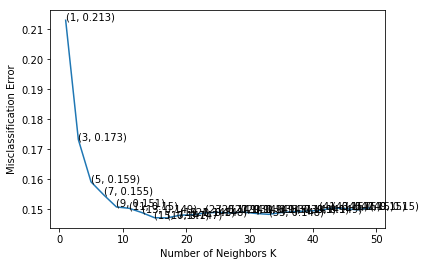

In [63]:
x_train_weighted_stand = scale.fit_transform(x_train_weighted)
x_test_weighted_stand = scale.fit_transform(x_test_weighted)
print(x_train_weighted_stand.shape)
print(x_test_weighted_stand.shape)

#getting optimal_k value
optimal_k = optimal_k_val(x=x_train_weighted_stand,y=y_train)

### Brute

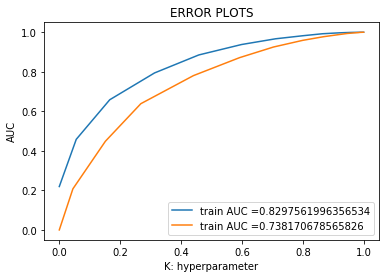

In [64]:
from sklearn.metrics import roc_curve, auc

neigh = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'brute')
neigh.fit(x_train_weighted_stand, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(x_train_weighted_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test_weighted_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix on Train data

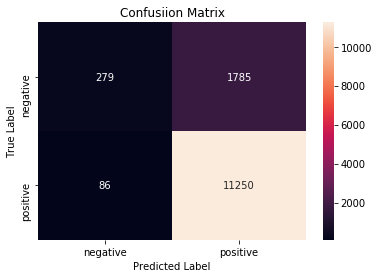

------------------------------------------------------
             precision    recall  f1-score   support

          0       0.76      0.14      0.23      2064
          1       0.86      0.99      0.92     11336

avg / total       0.85      0.86      0.82     13400



In [65]:
# predict the response
y_pred_weighted = neigh.predict(x_train_weighted_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train,y_pred_weighted)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('------------------------------------------------------')
print(classification_report(y_train ,y_pred_weighted))

### Confusion Matrix on Test data

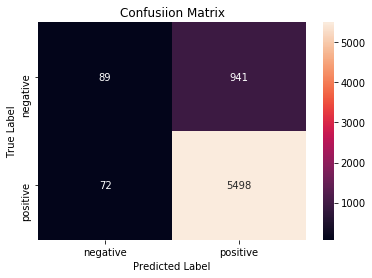

------------------------------------------------------
             precision    recall  f1-score   support

          0       0.55      0.09      0.15      1030
          1       0.85      0.99      0.92      5570

avg / total       0.81      0.85      0.80      6600



In [66]:
# predict the response
y_pred_weighted = neigh.predict(x_test_weighted_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred_weighted)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('------------------------------------------------------')
print(classification_report(y_test ,y_pred_weighted))

### Kd_tree


The optimal number of neighbors is 17.


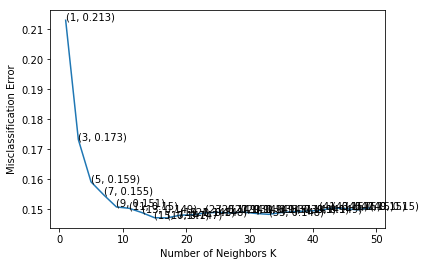

In [67]:
#getting optimal_k value
optimal_k = optimal_k_val(x=x_train_weighted_stand,y=y_train,alg = 'kd_tree')

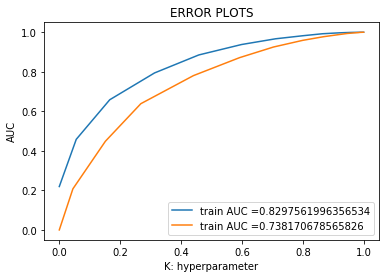

In [68]:
from sklearn.metrics import roc_curve, auc

neigh = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'kd_tree')
neigh.fit(x_train_weighted_stand, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(x_train_weighted_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test_weighted_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix for Train Data

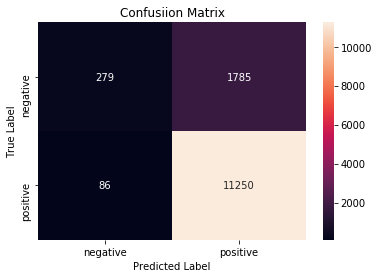

------------------------------------------------------
             precision    recall  f1-score   support

          0       0.76      0.14      0.23      2064
          1       0.86      0.99      0.92     11336

avg / total       0.85      0.86      0.82     13400



In [69]:
# predict the response
y_pred_weighted = neigh.predict(x_train_weighted_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train,y_pred_weighted)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('------------------------------------------------------')
print(classification_report(y_train ,y_pred_weighted))

### Confusion Matrix for Test Data

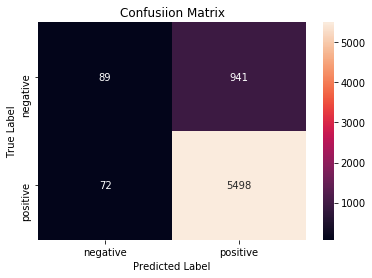

------------------------------------------------------
             precision    recall  f1-score   support

          0       0.55      0.09      0.15      1030
          1       0.85      0.99      0.92      5570

avg / total       0.81      0.85      0.80      6600



In [70]:
# predict the response
y_pred_weighted = neigh.predict(x_test_weighted_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred_weighted)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('------------------------------------------------------')
print(classification_report(y_test ,y_pred_weighted))

# Conclusion

In [71]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer ", "Model", "Hyper Parameter", "AUC"]
x.add_row(["BOW", "Brute", 7 , .67])
x.add_row(["BOW", "Kd-tree", 9 , .69])
x.add_row(["TF-IDF", "Brute", 11  , .75])
x.add_row(["TF-IDF", "Kd-tree", 15  , .69])
x.add_row(["AVG W2V", "Brute", 15 , .77])
x.add_row(["AVG W2V", "Kd-tree", 15 , .77])
x.add_row(["TF-IDF weighted W2V", "Brute", 17 , .73])
x.add_row(["TF-IDF weighted W2V", "Kd-tree", 17 , .73])

print(x)

+---------------------+---------+-----------------+------+
|     Vectorizer      |  Model  | Hyper Parameter | AUC  |
+---------------------+---------+-----------------+------+
|         BOW         |  Brute  |        7        | 0.67 |
|         BOW         | Kd-tree |        9        | 0.69 |
|        TF-IDF       |  Brute  |        11       | 0.75 |
|        TF-IDF       | Kd-tree |        15       | 0.69 |
|       AVG W2V       |  Brute  |        15       | 0.77 |
|       AVG W2V       | Kd-tree |        15       | 0.77 |
| TF-IDF weighted W2V |  Brute  |        17       | 0.73 |
| TF-IDF weighted W2V | Kd-tree |        17       | 0.73 |
+---------------------+---------+-----------------+------+


# Observation

- From the above conclusion we can see that Avg W2V is the best vectorizer technique.
- AUC under Avg W2V is the highest among all other vectorizers i.e .77
- Kd_tree is more time consuming than brute force
- For BOW and Tf-idf<br>
    - While using kd-tree we have used less features to make the computation fast which result in increase in nearest                 neighbours<br>
    - Decreasing the number of features increases AUC for BOW but we can see a decrease in AUC for Tf-idf
- For Avg W2V and Tf-idf Weighted W2V<br>
    - As we have used dense matrix for both brute and kd-tree algorithms the AUC results the same.